Part 3 - History Dependence
===============================


    

In [1]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np

def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    


# Load the data:
with np.load('data.npz') as archive:
    original_spikes = archive['spikes_outputencoding']

# reduce resolution:
max_spikes_per_bin = 5 # <-- resolution reduction factor
spikes = reduce_resolution(original_spikes,factor=max_spikes_per_bin, sum_spikes=True)

# choose a subset of the data (one cell & one experimental condition):
cell = 1
condition = 1
N = spikes.shape[2] # number of trials
T = spikes.shape[3] # length of a trial
all_spiketrains = spikes[cell,condition,:,:] # N x T array containing only the subset of data that we picked
sum_spiketrains = all_spiketrains.sum(axis=0)

/work/jleugeri/decoding/local/lib/python2.7/site-packages/matplotlib/__init__.py:1039: UserWarning: Bad val "pyside" on line #38
	"backend      : pyside
"
	in file "/work/jleugeri/decoding/local/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc"
	Key backend: Unrecognized backend string "pyside": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


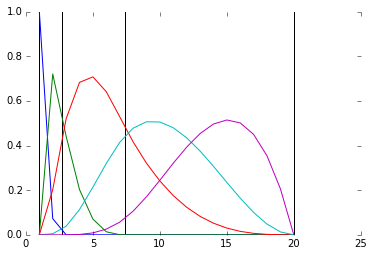

In [2]:
import splines
import statsmodels.api as sm

history_length = 100/max_spikes_per_bin
history_spline_order = 3                          
history_num_knots = 4

# Create spline history kernel
history_x = np.linspace(1+1e-10,history_length,history_length)                            # solution
history_knots = splines.augknt(np.logspace(0,np.log10(history_length),history_num_knots),history_spline_order)              # solution
history_knots = history_knots[:-1]
history_spline_bases = np.array(splines.spcol(history_x,history_knots,history_spline_order))   # solution

figure()
axes(frameon=False)
plot(np.tile(history_knots,(2,1)),np.zeros((2,len(history_knots)))+np.array([[0],[1]]), "k-")
plot(history_x,history_spline_bases);


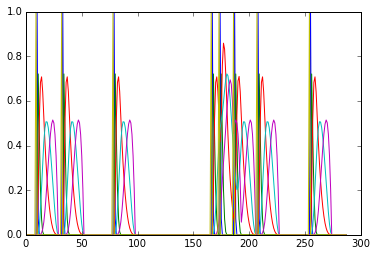

In [3]:
num_basis_functions = history_spline_bases.shape[1]

history_dm = np.zeros((N*T,num_basis_functions))

for i in range(num_basis_functions):
    history_dm[:,i] = np.convolve(all_spiketrains.ravel(), np.hstack([np.zeros_like(history_spline_bases[:,i]),history_spline_bases[:,i]]), "same")

plot(history_dm[:T/10])
plot(all_spiketrains.ravel()[:T/10])

In [15]:
import splines
from scipy.ndimage.filters import gaussian_filter1d


def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles

def calc_cum_abs_deriv(y, sigma=10, order=1):
    """ Calculates the curvature of the spike count vector `y`"""
    return np.cumsum(np.abs(gaussian_filter1d(y, sigma=sigma, order=order)))

sigma               = 10
spline_order        = 3
num_knots           = 50




cumulative_derivative = calc_cum_abs_deriv(sum_spiketrains, sigma=sigma, order=1)
adaptive_rate_knots   = find_percentiles(cumulative_derivative, num_knots)
knots                 = splines.augknt(adaptive_rate_knots, spline_order)
rate_spline_bases     = np.array(splines.spcol(range(T),knots,spline_order))
rate_dm               = np.tile(rate_spline_bases, (N,1))

#spikes_nospikes     = np.array([sum_spiketrains, max_spikes_per_bin*N - sum_spiketrains]).T
#model               = sm.GLM(spikes_nospikes,spline_bases,family=sm.families.Binomial())
#fitted_model        = model.fit()
#adaptive_AICs.append(fitted_model.aic)
#prediction_adaptive_knots   = fitted_model.predict(spline_bases)

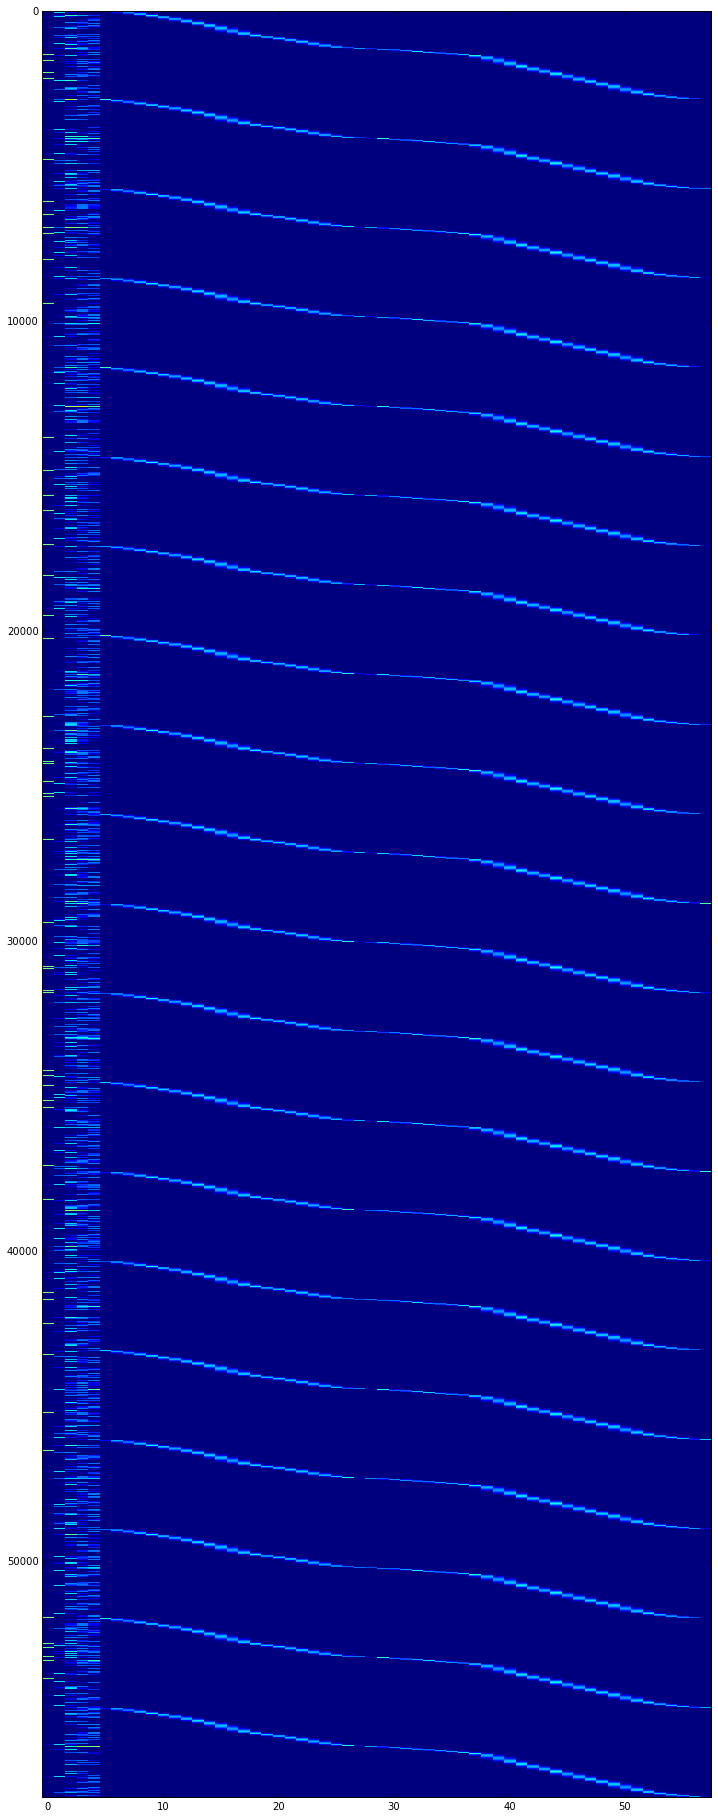

In [16]:
dm = np.hstack([history_dm, rate_dm])


figure(figsize=(12,32))
imshow(dm, aspect="auto", interpolation="nearest")

In [17]:
spikes_nospikes = np.array([all_spiketrains.ravel(),max_spikes_per_bin-all_spiketrains.ravel()]).T

model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
fitted_model = model.fit()

prediction = fitted_model.predict(dm[:T])

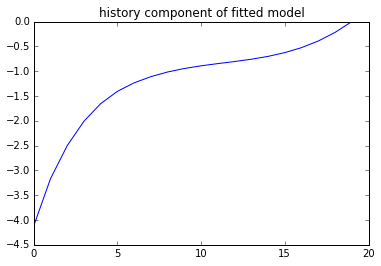

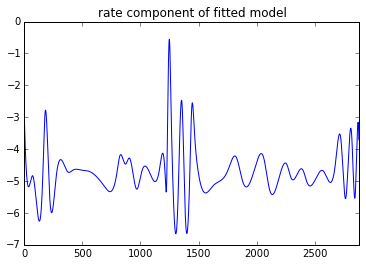

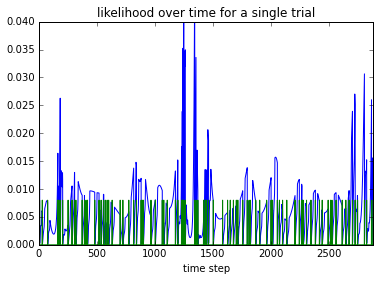

In [18]:
figure()
title('history component of fitted model')
plot(np.dot(history_spline_bases,fitted_model.params[:history_num_knots+1]))
xlim([0,history_spline_bases.shape[0]])

figure()
title('rate component of fitted model')
plot(np.dot(rate_spline_bases,fitted_model.params[history_num_knots+1:]))
xlim([0,T])

figure()

plot(prediction)
plot(all_spiketrains[0]/float(max_spikes_per_bin)*0.04)
xlim([0,T])
ylim([0,0.04])
title('likelihood over time for a single trial')
xlabel('time step')


Cross History
---------------

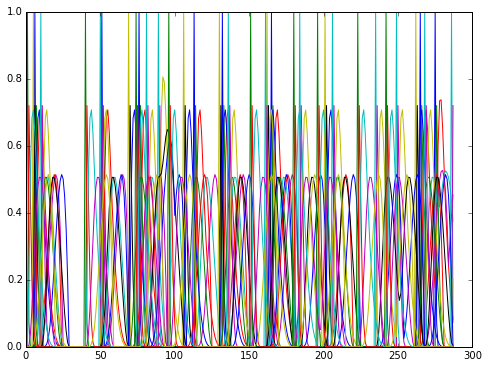

In [19]:
cross_cells = [0,2,3,4]
all_cross_spiketrains = spikes[cross_cells,condition,:,:]
num_basis_functions = history_spline_bases.shape[1]

cross_cell_dms = []

for c in range(len(cross_cells)):
    cross_cell_dm = np.zeros((N*T,num_basis_functions))
    for i in range(num_basis_functions):
        cross_cell_dm[:,i] = np.convolve(all_cross_spiketrains[c].ravel(), np.hstack([np.zeros_like(history_spline_bases[:,i]),history_spline_bases[:,i]]), "same")
    cross_cell_dms.append(cross_cell_dm)
    
cross_history_dm = np.hstack(cross_cell_dms)

figure(figsize=(8,6))
plot(cross_history_dm[:T/10])

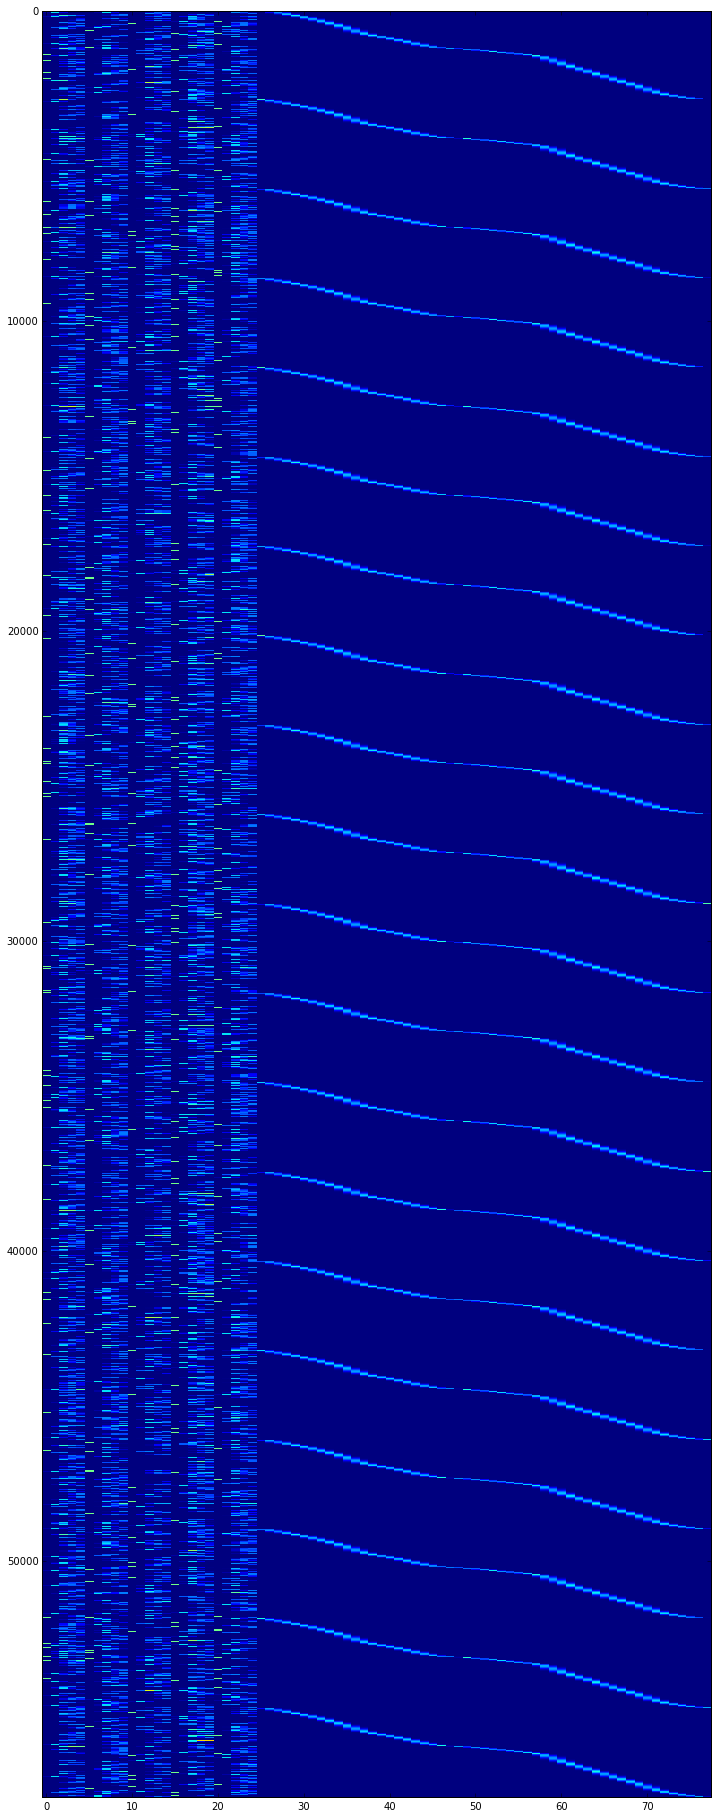

In [20]:
dm = np.hstack([history_dm, cross_history_dm, rate_dm])

figure(figsize=(12,32))
imshow(dm, aspect="auto", interpolation="nearest")

In [21]:
model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(dm[:T])                       # solution

In [22]:
auto_history_kernel = np.dot(history_spline_bases,fitted_model.params[:history_num_knots+1])
cross_history_kernels = np.hstack([np.dot(history_spline_bases,fitted_model.params[5+i*5:5+(i+1)*5]).reshape((-1,1)) for i in range(4)])

auto_history_component = np.dot(history_dm,fitted_model.params[:5])
cross_history_components = np.hstack([np.dot(history_dm,fitted_model.params[5+i*5:5+(i+1)*5]).reshape((-1,1)) for i in range(4)])
rate_component = np.dot(rate_dm,fitted_model.params[25:])

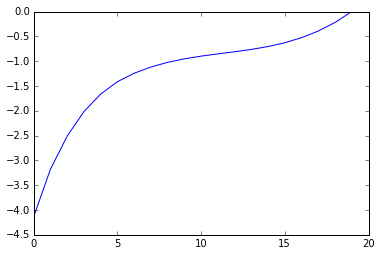

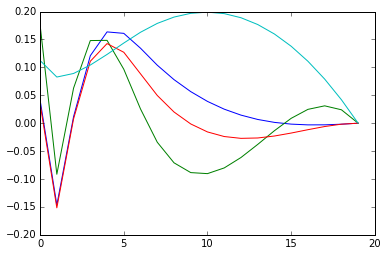

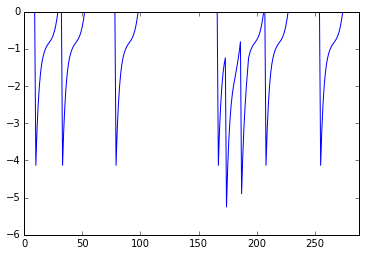

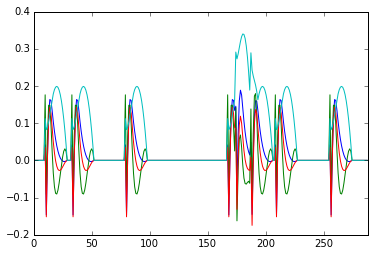

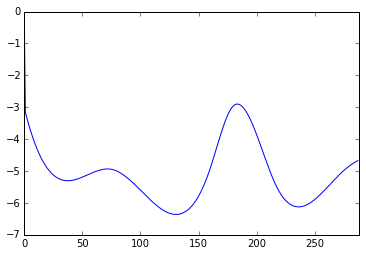

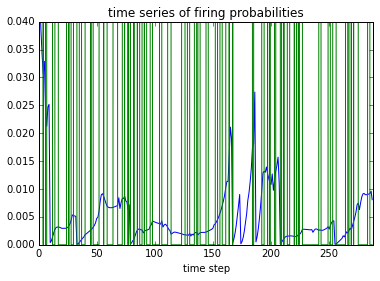

In [23]:
figure()
plot(auto_history_kernel)
xlim([0,len(auto_history_kernel)])

figure()
plot(cross_history_kernels)
xlim([0,len(auto_history_kernel)])

figure()
plot(auto_history_component[:T/10])
xlim([0,T/10])

figure()
plot(cross_history_components[:T/10])
xlim([0,T/10])
figure()
plot(rate_component[:T/10])
xlim([0,T/10])

figure()
plot(prediction[:T/10])
plot(sum_spiketrains[:T/10])
xlim([0,T/10])
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')

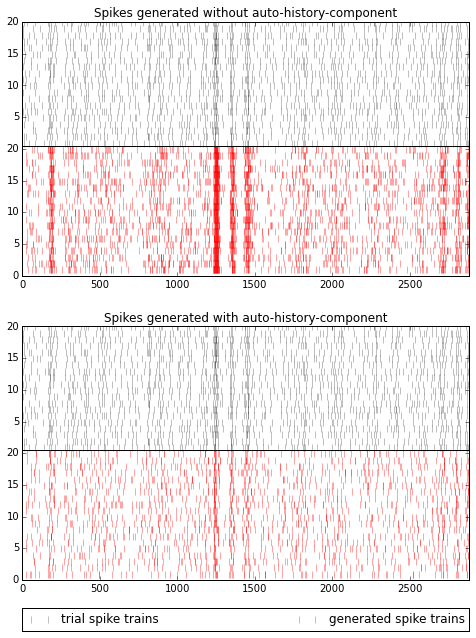

In [84]:
from numpy.random import binomial as binomial_rv

r_and_c_component = (cross_history_components.sum(axis=1) + rate_component).reshape((N,T))

figure(figsize=(8,10))
ax = [subplot(2,1,1), subplot(2,1,2)]


for i in range(2):
    ax[i].set_title("Spikes generated %s auto-history-component" % ("without" if i==0 else "with"))
    spike_train = np.zeros((N,T))
    for trial in range(N):
        for step in range(history_length,T):
            if i == 0:
                eta = r_and_c_component[trial,step]
            else:
                eta = r_and_c_component[trial,step] + np.dot(spike_train[trial,step-history_length:step],auto_history_kernel)
            p = 1/(1+np.exp(-eta))
            spike_train[trial,step] = binomial_rv(max_spikes_per_bin, p)
    spike_y, spike_t = np.where(spike_train)
    red_dots= ax[i].plot(spike_t,20-spike_y,"r|",alpha=0.7,ms=7)
    
    
spike_y, spike_t = np.where(all_spiketrains)
for i in range(2):
    black_dots = ax[i].plot(spike_t,40-spike_y,"k|",alpha=0.5,ms=7)
    ax[i].plot([0,T],[20.5,20.5],"k-")
    ax[i].set_yticks(np.arange(0,41,5))
    ax[i].set_yticklabels(np.hstack([np.arange(0,21,5),np.arange(5,21,5)]))
    ax[i].set_xlim([0,T])
ax[1].legend([black_dots[0], red_dots[0]], ["trial spike trains","generated spike trains"], bbox_to_anchor=(0., -0.2, 1., -0.2), loc=3, ncol=2, mode="expand", borderaxespad=0)

That's it for Part 3!
==========================